In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

In [4]:
inner_cv = KFold(n_splits = 3, shuffle=True,random_state=42)
outer_cv = KFold(n_splits = 15, shuffle=True,random_state=42)

Make Grid Search for Random Forest models.

In [8]:
hyperparams_RF = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [None, 5, 10, 20],
    'n_estimators' : [20,50,100]
}

grid_RF = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=hyperparams_RF,
    scoring='roc_auc',  # Beispiel für mehrklassige AUC
    cv=inner_cv,                     # innere CV (z.B. 3-fach)
)
scores_RF = cross_validate(grid_RF, X=X, y=y, cv=outer_cv, scoring=["roc_auc", "accuracy"], return_train_score=True)

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\User\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 

In [15]:
df = pd.DataFrame(scores_RF)

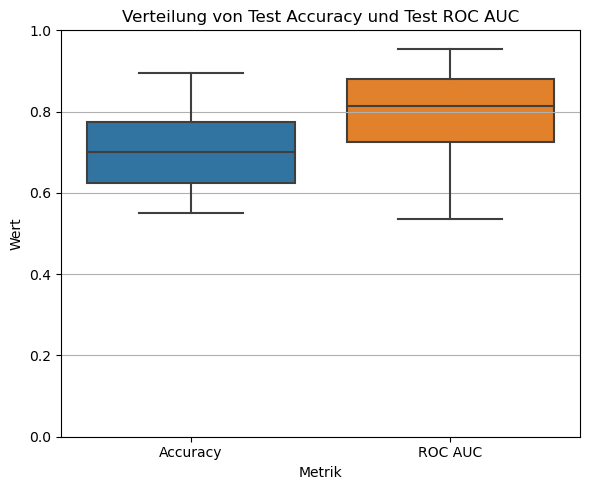

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Daten für Boxplot vorbereiten
plot_data = pd.DataFrame({
    'Metrik': ['Accuracy'] * len(df) + ['ROC AUC'] * len(df),
    'Wert': list(df['test_accuracy']) + list(df['test_roc_auc'])
})

# Boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(data=plot_data, x='Metrik', y='Wert')
plt.title('Verteilung von Test Accuracy und Test ROC AUC')
plt.ylim(0.0, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
